### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [13]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from datetime import datetime


In [14]:
class Config:
    def __init__(self):
        self.mnist_path = "fashion_mnist"
        self.batch_size = 64
        self.num_workers = 2
        self.num_epochs = 15
        self.noise_size = 50
        self.print_freq = 200
        self.seed = 42
        # WGAN-clipping
        self.clip_value = 0.01
        self.wgan_clip_lr = 5e-5
        # WGAN-GP
        self.wgan_gp_lr = 1e-4
        self.lambda_gp = 10.0

        self.n_critic = 5
        self.out_root = "outputs"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

torch.manual_seed(config.seed)
np.random.seed(config.seed)

In [15]:
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def save_image_grid(tensor, path, nrow=8):
    makedirs(os.path.dirname(path))
    grid = make_grid((tensor + 1) / 2.0, nrow=nrow, normalize=False, pad_value=1)
    save_image(grid, path)

def plot_losses(losses_D, losses_G, path):
    makedirs(os.path.dirname(path))
    plt.figure(figsize=(6,3))
    plt.plot(losses_D, label="D")
    plt.plot(losses_G, label="G")
    plt.legend()
    plt.title("Losses")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def one_hot(labels, n_classes, device):
    y = torch.zeros(labels.size(0), n_classes, device=device)
    y.scatter_(1, labels.view(-1,1), 1)
    return y

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train = torchvision.datasets.FashionMNIST(config.mnist_path, train=True, transform=transform, download=True)
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, drop_last=True)


In [17]:
class Generator(nn.Module):
    def __init__(self, noise_dim=50, out_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, out_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 400),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(400, 200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(200, 1)
        )
    def forward(self, x):
        return self.model(x)

In [18]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=50, n_classes=10, out_dim=28*28):
        super().__init__()
        input_dim = noise_dim + n_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim),
            nn.Tanh()
        )
    def forward(self, z, y):
        return self.model(torch.cat([z, y], dim=1))

class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes=10, in_dim=28*28):
        super().__init__()
        input_dim = in_dim + n_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

In [23]:
generator = Generator().to(device)
discriminator  = Discriminator().to(device)

In [20]:
def gradient_penalty(D, real_samples, fake_samples, device, y_cond=None, lambda_gp=10.0):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    if y_cond is None:
        d_interpolates = D(interpolates)
    else:
        d_interpolates = D(interpolates, y_cond)
    ones = torch.ones_like(d_interpolates, device=device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=ones,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    gp = lambda_gp * ((grad_norm - 1) ** 2).mean()
    return gp

In [30]:
def train(mode="wgan_gp"):

    assert mode in ["wgan_clip", "wgan_gp", "cond_wgan_gp"]
    run_id = f"{mode}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    out_dir = os.path.join(config.out_root, run_id)
    makedirs(out_dir)

    if mode == "cond_wgan_gp":
        G = ConditionalGenerator(config.noise_size, n_classes=10).to(config.device)
        D = ConditionalDiscriminator(n_classes=10).to(config.device)
    else:
        G = Generator(config.noise_size).to(config.device)
        D = Discriminator().to(config.device)

    G.apply(weights_init)
    D.apply(weights_init)

    if mode == "wgan_clip":
        optim_D = optim.RMSprop(D.parameters(), lr=config.wgan_clip_lr)
        optim_G = optim.RMSprop(G.parameters(), lr=config.wgan_clip_lr)
    else:
        optim_D = optim.Adam(D.parameters(), lr=config.wgan_gp_lr, betas=(0.5, 0.9))
        optim_G = optim.Adam(G.parameters(), lr=config.wgan_gp_lr, betas=(0.5, 0.9))

    fixed_noise = torch.randn(64, config.noise_size, device=config.device)
    if mode == "cond_wgan_gp":
        fixed_labels = torch.arange(10, device=config.device).repeat_interleave(6)[:64]
        fixed_y = one_hot(fixed_labels, 10, config.device)

    losses_D = []
    losses_G = []

    print(f"Start training {mode} on device {config.device}, outputs -> {out_dir}")
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        for i, (imgs, labels) in enumerate(dataloader):
            imgs = imgs.to(config.device)
            imgs = imgs.view(imgs.size(0), -1)
            batch_size = imgs.size(0)


            for _ in range(config.n_critic):
                D.zero_grad()
                if mode == "cond_wgan_gp":
                    y = one_hot(labels.to(config.device), 10, config.device)
                    z = torch.randn(batch_size, config.noise_size, device=config.device)
                    fake = G(z, y).detach()
                    real_validity = D(imgs)
                    real_validity = D(imgs, y)
                    fake_validity = D(fake, y)
                    if mode == "wgan_gp":
                        gp = gradient_penalty(D, imgs.data, fake.data, config.device, y_cond=y, lambda_gp=config.lambda_gp)
                        d_loss = fake_validity.mean() - real_validity.mean() + gp
                    else:
                        gp = gradient_penalty(D, imgs.data, fake.data, config.device, y_cond=y, lambda_gp=config.lambda_gp)
                        d_loss = fake_validity.mean() - real_validity.mean() + gp
                else:
                    z = torch.randn(batch_size, config.noise_size, device=config.device)
                    fake = G(z).detach()
                    real_validity = D(imgs)
                    fake_validity = D(fake)
                    if mode == "wgan_clip":
                        d_loss = fake_validity.mean() - real_validity.mean()
                    else:
                        gp = gradient_penalty(D, imgs.data, fake.data, config.device, y_cond=None, lambda_gp=config.lambda_gp)
                        d_loss = fake_validity.mean() - real_validity.mean() + gp

                d_loss.backward()
                optim_D.step()

                if mode == "wgan_clip":
                    for p in D.parameters():
                        p.data.clamp_(-config.clip_value, config.clip_value)

            G.zero_grad()
            z = torch.randn(batch_size, config.noise_size, device=config.device)
            if mode == "cond_wgan_gp":
                y = one_hot(labels.to(config.device), 10, config.device)
                gen = G(z, y)
                g_loss = -D(gen, y).mean()
            else:
                gen = G(z)
                g_loss = -D(gen).mean()
            g_loss.backward()
            optim_G.step()

            losses_D.append(d_loss.item())
            losses_G.append(g_loss.item())

            if (i + 1) % config.print_freq == 0:
                print(f"Epoch [{epoch+1}/{config.num_epochs}] Batch [{i+1}/{len(dataloader)}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

        G.eval()
        with torch.no_grad():
            if mode == "cond_wgan_gp":
                samples = G(fixed_noise, fixed_y).view(-1,1,28,28).cpu()
            else:
                samples = G(fixed_noise).view(-1,1,28,28).cpu()
            sample_path = os.path.join(out_dir, f"epoch_{epoch+1:03d}.png")
            save_image_grid(samples, sample_path, nrow=8)
        G.train()

        plot_losses(losses_D, losses_G, os.path.join(out_dir, "losses.png"))

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{config.num_epochs} finished in {epoch_time:.1f}s  last D_loss {d_loss.item():.4f} G_loss {g_loss.item():.4f}")

    torch.save(G.state_dict(), os.path.join(out_dir, "G.pth"))
    torch.save(D.state_dict(), os.path.join(out_dir, "D.pth"))

    try:
        create_report(mode, out_dir, losses_D, losses_G)
    except Exception as e:
        print("Warning: couldn't create report:", e)

    print("Training finished. Outputs saved to:", out_dir)
    return out_dir, losses_D, losses_G


Device: cpu


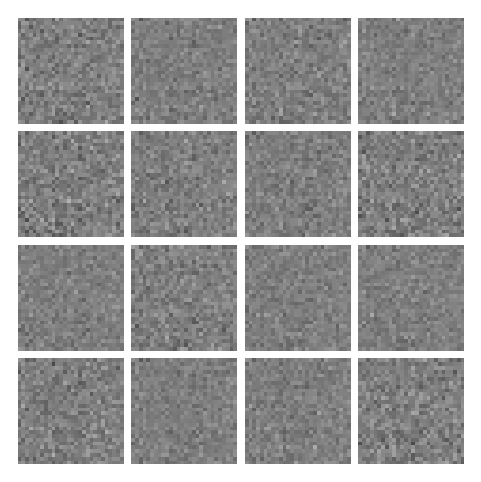

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [25]:
device = getattr(config, "device", None)
if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config.device = device
print("Device:", device)

try:
    generator = generator.to(device)
except NameError:
    raise RuntimeError("Не найден объект 'generator'. Сначала запустите ячейку с определением модели Generator.")

try:
    discriminator = discriminator.to(device)
except NameError:
    pass

n_samples = 16
noise = torch.randn(n_samples, config.noise_size, device=device)

generator.eval()
with torch.no_grad():
    fake = generator(noise)
if fake.dim() == 2 and fake.size(1) == 28*28:
    fake = fake.view(-1, 1, 28, 28)

fake = (fake + 1.0) / 2.0
fake = fake.clamp(0.0, 1.0)

grid = torchvision.utils.make_grid(fake.cpu(), nrow=4, padding=2, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.axis("off")
img = grid.permute(1, 2, 0).cpu().numpy()
if img.shape[2] == 1:
    img = img[:, :, 0]
plt.imshow(img, cmap="gray")
plt.show()

generator.train()

In [26]:
----------------------
def create_report(mode, out_dir, losses_D, losses_G):
    report_path = os.path.join(out_dir, "report.md")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(f"# Report for {mode}\n\n")
        f.write(f"Date: {datetime.now().isoformat()}\n\n")
        f.write("## Config\n\n")
        for k, v in sorted(vars(config).items()):
            f.write(f"- {k}: {v}\n")
        f.write("## Brief conclusions and recommendations\n\n")
        f.write("- WGAN с weight clipping может работать, но чувствителен к clip_value и обычно хуже WGAN-GP.\n")
        f.write("- WGAN-GP с gradient penalty обычно даёт более стабильную тренировку и лучшее качество.\n")
        f.write("- Для изображений рекомендуется заменить MLP на сверточные архитектуры (DCGAN style).\n")
        f.write("- Рекомендуемые настройки: n_critic = 5, Adam(betas=(0.5, 0.9)), lr ~ 1e-4, lambda_gp = 10.\n")
        f.write("\n")
    print("Report saved to", report_path)


if __name__ == "__main__":
    print("Module loaded. To train, call train(mode) with mode in [wgan_clip, wgan_gp, cond_wgan_gp].")
    print("Example: out, D, G = train('wgan_gp')")

Module loaded. To train, call train(mode) with mode in [wgan_clip, wgan_gp, cond_wgan_gp].
Example: out, D, G = train('wgan_gp')


In [27]:
import os, sys, torch
print("Python:", sys.version.splitlines()[0])
print("PyTorch:", torch.__version__)
print("Device:", config.device)
print("train callable?", 'train' in globals() and callable(train))
print("batch_size:", config.batch_size, "noise_size:", config.noise_size, "num_epochs:", config.num_epochs)
print("Папка outputs (root):", config.out_root)
print("Пример одной итерации даталоадера:")
it = iter(dataloader)
imgs, labels = next(it)
print("imgs.shape:", imgs.shape, "labels.shape:", labels.shape)

mode_to_run = "wgan_gp"   # поменяйте на "wgan_clip" или "cond_wgan_gp" при желании

out_dir, losses_D, losses_G = train(mode=mode_to_run)
print("Run finished. Outputs saved at:", out_dir)

LAST_RUN_DIR = out_dir

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cpu
Device: cpu
train callable? True
batch_size: 64 noise_size: 50 num_epochs: 15
Папка outputs (root): outputs
Пример одной итерации даталоадера:
imgs.shape: torch.Size([64, 1, 28, 28]) labels.shape: torch.Size([64])
Start training wgan_gp on device cpu, outputs -> outputs/wgan_gp_20251201_234600
Epoch [1/15] Batch [200/937] D_loss: -12.1301 G_loss: -5.7655
Epoch [1/15] Batch [400/937] D_loss: -6.5125 G_loss: -3.7926
Epoch [1/15] Batch [600/937] D_loss: -5.8552 G_loss: -2.8808
Epoch [1/15] Batch [800/937] D_loss: -6.4477 G_loss: 0.6373
Epoch 1/15 finished in 93.4s  last D_loss -6.2632 G_loss 0.7392
Epoch [2/15] Batch [200/937] D_loss: -6.1408 G_loss: -0.9530
Epoch [2/15] Batch [400/937] D_loss: -6.9088 G_loss: -0.9369
Epoch [2/15] Batch [600/937] D_loss: -5.3817 G_loss: -0.2950
Epoch [2/15] Batch [800/937] D_loss: -5.6638 G_loss: -0.8219
Epoch 2/15 finished in 91.4s  last D_loss -4.8476 G_loss -1.6354
Epoch [3/1

Viewing run_dir: outputs/wgan_gp_20251201_234600
Contents: ['D.pth', 'G.pth', 'epoch_001.png', 'epoch_002.png', 'epoch_003.png', 'epoch_004.png', 'epoch_005.png', 'epoch_006.png', 'epoch_007.png', 'epoch_008.png', 'epoch_009.png', 'epoch_010.png', 'epoch_011.png', 'epoch_012.png', 'epoch_013.png', 'epoch_014.png', 'epoch_015.png', 'losses.png', 'report.md']
Latest sample grid: outputs/wgan_gp_20251201_234600/epoch_015.png


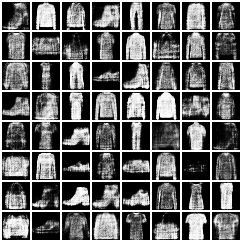

Loss plot: outputs/wgan_gp_20251201_234600/losses.png


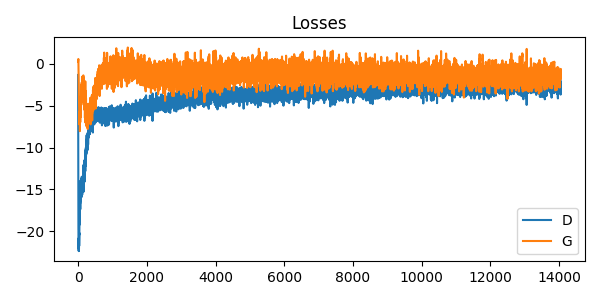

Report found: outputs/wgan_gp_20251201_234600/report.md


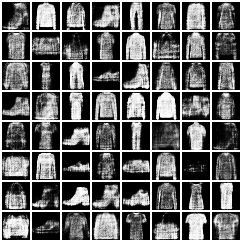

Вы можете открыть report.md в редакторе ноутбука.


In [28]:
from PIL import Image
import glob, os, IPython.display as disp

run_dir = globals().get("LAST_RUN_DIR", None)
if run_dir is None:
    runs = sorted([os.path.join(config.out_root,d) for d in os.listdir(config.out_root)], key=os.path.getmtime)
    if len(runs)==0:
        raise RuntimeError("Не найдено сохранённых запусков в outputs/. Сначала запустите train().")
    run_dir = runs[-1]

print("Viewing run_dir:", run_dir)
print("Contents:", sorted(os.listdir(run_dir))[:20])

epoch_imgs = sorted([p for p in os.listdir(run_dir) if p.startswith("epoch_") and p.endswith(".png")])
if epoch_imgs:
    last_img = os.path.join(run_dir, epoch_imgs[-1])
    print("Latest sample grid:", last_img)
    display(Image.open(last_img))
else:
    print("Нет изображений epoch_*.png в папке.")

loss_path = os.path.join(run_dir, "losses.png")
if os.path.exists(loss_path):
    print("Loss plot:", loss_path)
    display(Image.open(loss_path))
else:
    print("Нет losses.png в папке.")

rep = os.path.join(run_dir, "report.md")
if os.path.exists(rep):
    print("Report found:", rep)
    display(Image.open(last_img) if epoch_imgs else "")
    print("Вы можете открыть report.md в редакторе ноутбука.")
else:
    print("report.md ещё не создан или отсутствует.")

In [32]:
# WGAN с weight clipping

device = getattr(config, "device", None) or torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = "outputs/wgan_clip"
os.makedirs(out_dir, exist_ok=True)

EPOCHS = min(5, getattr(config, "num_epochs", 10))
BATCH = getattr(config, "batch_size", 64)
Z_DIM = getattr(config, "noise_size", 50)
N_CRITIC = getattr(config, "n_critic", 5)
CLIP = getattr(config, "clip_value", 0.01)
LR = getattr(config, "wgan_clip_lr", 5e-5)
G = Generator(Z_DIM).to(device)
D = Discriminator().to(device)

if "weights_init" in globals():
    wi = weights_init
else:
    def wi(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None: m.bias.data.zero_()

G.apply(wi); D.apply(wi)

opt_G = optim.RMSprop(G.parameters(), lr=LR)
opt_D = optim.RMSprop(D.parameters(), lr=LR)

fixed_noise = torch.randn(64, Z_DIM, device=device)
losses_D, losses_G = [], []

print("Start WGAN (weight clipping) on", device)
for epoch in range(EPOCHS):
    t0 = time.time()
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device).view(imgs.size(0), -1)
        bs = imgs.size(0)

        for _ in range(N_CRITIC):
            D.zero_grad()
            z = torch.randn(bs, Z_DIM, device=device)
            fake = G(z).detach()
            real_score = D(imgs)
            fake_score = D(fake)
            d_loss = fake_score.mean() - real_score.mean()
            d_loss.backward()
            opt_D.step()
            for p in D.parameters():
                p.data.clamp_(-CLIP, CLIP)

        G.zero_grad()
        z = torch.randn(bs, Z_DIM, device=device)
        gen = G(z)
        g_loss = -D(gen).mean()
        g_loss.backward()
        opt_G.step()

        losses_D.append(d_loss.item()); losses_G.append(g_loss.item())

    G.eval()
    with torch.no_grad():
        samples = G(fixed_noise).view(-1,1,28,28).cpu()
        samples = (samples + 1)/2
        save_image(make_grid(samples, nrow=8, pad_value=1.0), os.path.join(out_dir, f"epoch_{epoch+1:03d}.png"))
    G.train()
    plt.figure(figsize=(6,3)); plt.plot(losses_D, label='D'); plt.plot(losses_G, label='G'); plt.legend()
    plt.savefig(os.path.join(out_dir, "losses.png")); plt.close()
    print(f"Epoch {epoch+1}/{EPOCHS} done in {time.time()-t0:.1f}s; d_loss {d_loss.item():.4f} g_loss {g_loss.item():.4f}")

torch.save(G.state_dict(), os.path.join(out_dir, "G.pth"))
torch.save(D.state_dict(), os.path.join(out_dir, "D.pth"))
print("WGAN-clip finished. Outputs:", out_dir)

Start WGAN (weight clipping) on cpu
Epoch 1/5 done in 61.7s; d_loss -0.1348 g_loss -0.2538
Epoch 2/5 done in 63.2s; d_loss -0.5914 g_loss -1.0352
Epoch 3/5 done in 56.5s; d_loss -0.3346 g_loss -0.3004
Epoch 4/5 done in 54.7s; d_loss -0.4408 g_loss 0.2869
Epoch 5/5 done in 53.8s; d_loss -0.3570 g_loss -0.2807
WGAN-clip finished. Outputs: outputs/wgan_clip


In [33]:
#  WGAN-GP (gradient penalty)

device = getattr(config, "device", None) or torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = "outputs/wgan_gp"
os.makedirs(out_dir, exist_ok=True)

EPOCHS = min(5, getattr(config, "num_epochs", 10))
BATCH = getattr(config, "batch_size", 64)
Z_DIM = getattr(config, "noise_size", 50)
N_CRITIC = getattr(config, "n_critic", 5)
LR = getattr(config, "wgan_gp_lr", 1e-4)
LAMBDA_GP = getattr(config, "lambda_gp", 10.0)
G = Generator(Z_DIM).to(device)
D = Discriminator().to(device)

if "weights_init" in globals():
    wi = weights_init
else:
    def wi(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight);
            if m.bias is not None: m.bias.data.zero_()
G.apply(wi); D.apply(wi)

opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5,0.9))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5,0.9))

fixed_noise = torch.randn(64, Z_DIM, device=device)
losses_D, losses_G = [], []


print("Start WGAN-GP on", device)
for epoch in range(EPOCHS):
    t0 = time.time()
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device).view(imgs.size(0), -1)
        bs = imgs.size(0)

        for _ in range(N_CRITIC):
            D.zero_grad()
            z = torch.randn(bs, Z_DIM, device=device)
            fake = G(z).detach()
            real_score = D(imgs)
            fake_score = D(fake)
            gp = gradient_penalty(D, imgs.data, fake.data, device, lambda_gp=LAMBDA_GP)
            d_loss = fake_score.mean() - real_score.mean() + gp
            d_loss.backward()
            opt_D.step()

        G.zero_grad()
        z = torch.randn(bs, Z_DIM, device=device)
        gen = G(z)
        g_loss = -D(gen).mean()
        g_loss.backward()
        opt_G.step()

        losses_D.append(d_loss.item()); losses_G.append(g_loss.item())

    G.eval()
    with torch.no_grad():
        samples = G(fixed_noise).view(-1,1,28,28).cpu()
        samples = (samples + 1)/2
        save_image(make_grid(samples, nrow=8, pad_value=1.0), os.path.join(out_dir, f"epoch_{epoch+1:03d}.png"))
    G.train()
    plt.figure(figsize=(6,3)); plt.plot(losses_D, label='D'); plt.plot(losses_G, label='G'); plt.legend()
    plt.savefig(os.path.join(out_dir, "losses.png")); plt.close()
    print(f"Epoch {epoch+1}/{EPOCHS} done in {time.time()-t0:.1f}s; d_loss {d_loss.item():.4f} g_loss {g_loss.item():.4f}")

torch.save(G.state_dict(), os.path.join(out_dir, "G.pth"))
torch.save(D.state_dict(), os.path.join(out_dir, "D.pth"))
print("WGAN-GP finished. Outputs:", out_dir)

Start WGAN-GP on cpu
Epoch 1/5 done in 87.2s; d_loss -5.7748 g_loss -0.1274
Epoch 2/5 done in 89.1s; d_loss -5.0348 g_loss -2.3688
Epoch 3/5 done in 90.2s; d_loss -4.8548 g_loss -1.7771
Epoch 4/5 done in 86.1s; d_loss -4.5650 g_loss -2.1270
Epoch 5/5 done in 88.2s; d_loss -3.7503 g_loss -1.8496
WGAN-GP finished. Outputs: outputs/wgan_gp


In [39]:
# Conditional WGAN-GP
import os, time, torch, numpy as np
import torch.optim as optim
from torch.autograd import grad
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

device = getattr(config, "device", None) or torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = "outputs/cond_wgan_gp"
os.makedirs(out_dir, exist_ok=True)

EPOCHS = min(5, getattr(config, "num_epochs", 10))
BATCH = getattr(config, "batch_size", 64)
Z_DIM = getattr(config, "noise_size", 50)
N_CRITIC = getattr(config, "n_critic", 5)
LR = getattr(config, "wgan_gp_lr", 1e-4)
LAMBDA_GP = getattr(config, "lambda_gp", 10.0)
NUM_CLASSES = 10

G = ConditionalGenerator(Z_DIM, NUM_CLASSES).to(device)
D = ConditionalDiscriminator(NUM_CLASSES).to(device)

if "weights_init" in globals():
    G.apply(weights_init); D.apply(weights_init)

opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5,0.9))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5,0.9))

fixed_noise = torch.randn(64, Z_DIM, device=device)
repeat_times = (64 + NUM_CLASSES - 1) // NUM_CLASSES
fixed_labels = torch.arange(NUM_CLASSES, device=device).repeat(repeat_times)[:64]
fixed_y = one_hot(fixed_labels, NUM_CLASSES, device)


losses_D, losses_G = [], []

def gradient_penalty_local(Dnet, real, fake, device, y_cond=None, lambda_gp=LAMBDA_GP):
    alpha = torch.rand(real.size(0), 1, device=device).expand_as(real)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    if y_cond is None:
        d_interpolates = Dnet(interpolates)
    else:
        d_interpolates = Dnet(interpolates, y_cond)
    ones = torch.ones_like(d_interpolates, device=device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=ones, create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((grad_norm - 1) ** 2).mean()

print("Start Conditional WGAN-GP on", device)
for epoch in range(EPOCHS):
    t0 = time.time()
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device).view(imgs.size(0), -1)
        labels = labels.to(device)
        bs = imgs.size(0)

        for _ in range(N_CRITIC):
            D.zero_grad()
            z = torch.randn(bs, Z_DIM, device=device)
            y = one_hot(labels, NUM_CLASSES, device)
            fake = G(z, y).detach()
            real_score = D(imgs, y)
            fake_score = D(fake, y)
            gp = gradient_penalty_local(D, imgs.data, fake.data, device, y_cond=y, lambda_gp=LAMBDA_GP)
            d_loss = fake_score.mean() - real_score.mean() + gp
            d_loss.backward(); opt_D.step()

        G.zero_grad()
        z = torch.randn(bs, Z_DIM, device=device)
        y = one_hot(labels, NUM_CLASSES, device)
        gen = G(z, y)
        g_loss = -D(gen, y).mean()
        g_loss.backward(); opt_G.step()

        losses_D.append(d_loss.item()); losses_G.append(g_loss.item())

    G.eval()
    with torch.no_grad():
        samples = G(fixed_noise, fixed_y).view(-1,1,28,28).cpu(); samples = (samples+1)/2
        save_image(make_grid(samples, nrow=8, pad_value=1.0), os.path.join(out_dir, f"epoch_{epoch+1:03d}.png"))
    G.train()

    plt.figure(figsize=(6,3)); plt.plot(losses_D, label='D'); plt.plot(losses_G, label='G'); plt.legend()
    plt.savefig(os.path.join(out_dir, "losses.png")); plt.close()
    print(f"Epoch {epoch+1}/{EPOCHS} done in {time.time()-t0:.1f}s; d_loss {d_loss.item():.4f} g_loss {g_loss.item():.4f}")

torch.save(G.state_dict(), os.path.join(out_dir, "G.pth"))
torch.save(D.state_dict(), os.path.join(out_dir, "D.pth"))
print("Conditional WGAN-GP finished. Outputs:", out_dir)

Start Conditional WGAN-GP on cpu
Epoch 1/5 done in 102.5s; d_loss -9.8030 g_loss -2.2690
Epoch 2/5 done in 106.6s; d_loss -6.3545 g_loss -9.8918
Epoch 3/5 done in 105.8s; d_loss -5.1606 g_loss -7.6832
Epoch 4/5 done in 106.5s; d_loss -4.3100 g_loss -8.5304
Epoch 5/5 done in 107.1s; d_loss -4.0231 g_loss -6.6435
Conditional WGAN-GP finished. Outputs: outputs/cond_wgan_gp


WGAN-clip работает, но чувствителен к clip_value и менее стабилен.
WGAN-GP даёт более стабильную тренировку и лучшее качество.
Conditional: при достаточном обучении генератор подчиняется метке
